In [1]:
from pathlib import Path
import pickle
import glob
import os
from thalamocortex.models import CTCNet
from thalamocortex.utils import create_data_loaders, get_neuron_weights, plot_receptive_field
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from scipy.special import softmax
from scipy.stats import entropy

/Users/patmccarthy/miniconda3/envs/thalamocortex/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "/Users/patmccarthy/Documents/phd/rotation1"

Load results

In [3]:
results_paths = {
    "ff_MNIST_1": "/Users/patmccarthy/Documents/thalamocortex/results/25_02_24_feedforward_mnist_gridsearch2/0_CTCNet_TC_none",
    # "ff_MNIST_2": "/Users/patmccarthy/Documents/thalamocortex/results/25_02_24_feedforward_mnist_gridsearch2/1_CTCNet_TC_none",
    "ff_MNIST_finetune": "/Users/patmccarthy/Documents/thalamocortex/results/26_02_24_feedforward_finetune_binarymnist_run3/0_CTCNet_finetuning_ThalReadout_2",
    # "mod1_LeftRightMNIST_2": "/Users/patmccarthy/Documents/thalamocortex/results/21_02_24_mod1_leftrightmnist_gridsearch2/1_CTCNet_TC_multi_pre_activation_reciprocal",
    # "mod1_LeftRightMNIST_3": "/Users/patmccarthy/Documents/thalamocortex/results/21_02_24_mod1_leftrightmnist_gridsearch2/2_CTCNet_TC_multi_pre_activation_reciprocal",
    # "mod1_LeftRightMNIST_4": "/Users/patmccarthy/Documents/thalamocortex/results/21_02_24_mod1_leftrightmnist_gridsearch2/3_CTCNet_TC_multi_pre_activation_reciprocal",
}

In [4]:
results_paths

{'ff_MNIST_1': '/Users/patmccarthy/Documents/thalamocortex/results/25_02_24_feedforward_mnist_gridsearch2/0_CTCNet_TC_none',
 'ff_MNIST_finetune': '/Users/patmccarthy/Documents/thalamocortex/results/26_02_24_feedforward_finetune_binarymnist_run3/0_CTCNet_finetuning_ThalReadout_2'}

Final validation losses

In [5]:
results = {}
for model_name, path in results_paths.items():
    
    # learning progress
    with open(Path(f"{path}", "learning.pkl"), "rb") as handle:
        learning = pickle.load(handle)

    results[model_name] = {"val_losses": learning["val_losses"],
                           "train_losses": learning["train_losses"],
                           "train_time": learning["train_time"],
                           "state_dicts": learning["state_dicts"]}

In [6]:
learning.keys()

dict_keys(['train_losses', 'val_losses', 'final_val_losses', 'state_dicts', 'train_time'])

In [7]:
results.keys()

dict_keys(['ff_MNIST_1', 'ff_MNIST_finetune'])

In [8]:
model_plot_list = ["ff_MNIST_finetune"]

Text(0.5, 0, 'model')

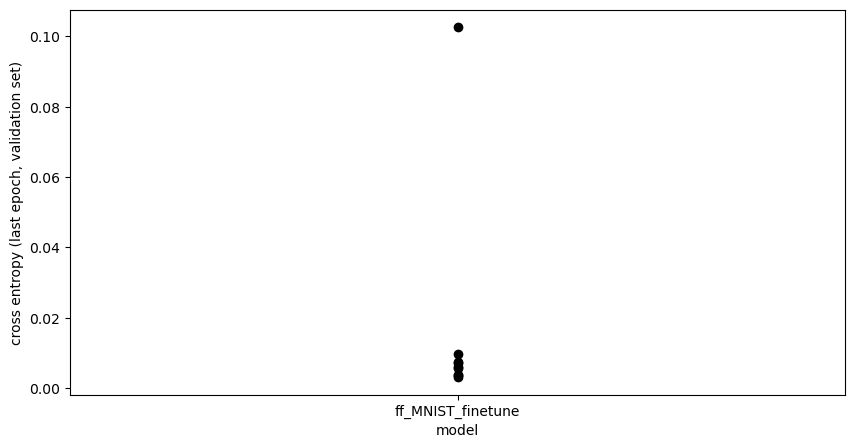

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
models_plotted = []
models_plotted_idx = 0
for _, (model_name, model_results) in enumerate(results.items()):
    if model_name in model_plot_list:
        models_plotted.append(model_name)
        models_plotted_idx += 1
        losses = model_results["val_losses"][-1]
        for point in losses:
            ax.scatter(models_plotted_idx, point, c="k")
ax.set_xticks(range(1, len(models_plotted)+1), models_plotted)
ax.set_ylabel("cross entropy (last epoch, validation set)")
ax.set_xlabel("model")
# ax.set_ylim(0, 0.2)

Learning curves

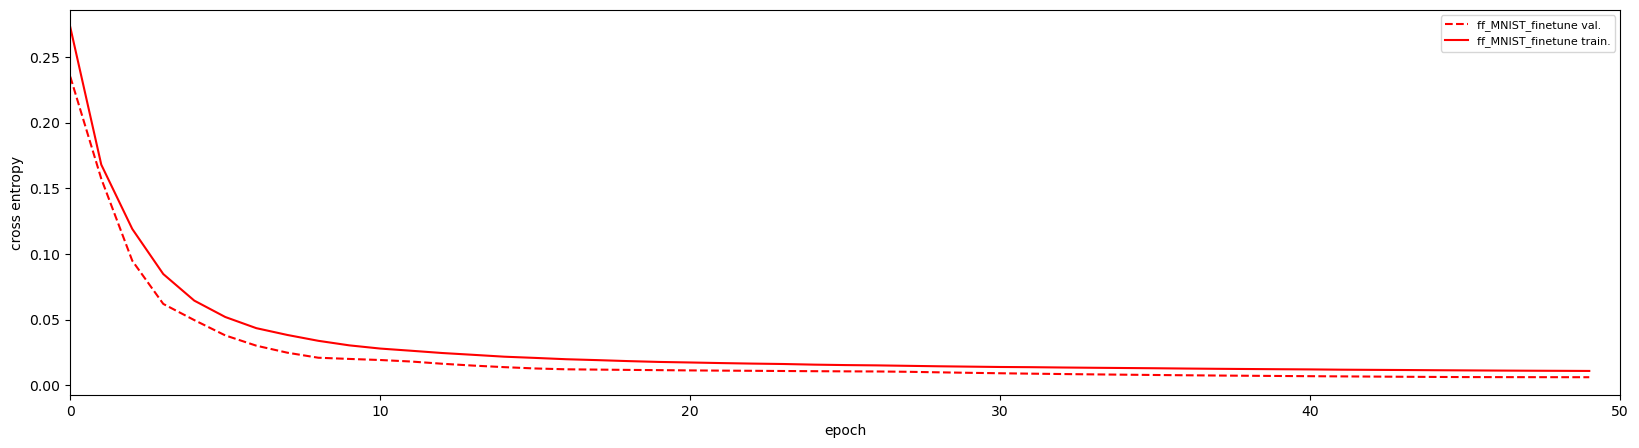

In [10]:
n_epochs = len(results[model_plot_list[0]]["val_losses"])
colours = ["r", "g", "b", "m"]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
models_plotted = []
models_plotted_idx = 0
for _, (model_name, model_results) in enumerate(results.items()):
    if model_name in model_plot_list:
        models_plotted.append(model_name)
        models_plotted_idx += 1

        n_epochs = len(model_results["val_losses"])

        ax.plot(np.arange(n_epochs), np.median(np.array(model_results["val_losses"]), axis=-1), ls="--", label=f"{model_name} val.", c=colours[models_plotted_idx-1])
        ax.plot(np.arange(n_epochs), np.median(np.array(model_results["train_losses"]), axis=-1), ls="-", label=f"{model_name} train.", c=colours[models_plotted_idx-1])

# ax.set_xticks(range(1, len(models_plotted)+1), models_plotted)
ax.set_ylabel("cross entropy")
ax.set_xlabel("epoch")
ax.set_xlim(0, n_epochs)
ax.legend(fontsize=8)
# ax.set_ylim(0, 0.2)

Analysis of initial and final weight distributions

In [11]:
state_dicts = results["ff_MNIST_finetune"]["state_dicts"]

In [12]:
trained_epoch = 49

n_bins=85
n_bins=2
n_bins=4181
n_bins=5
n_bins=85
n_bins=5
n_bins=53


/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_7554/1326329667.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(3, 3))


n_bins=3
n_bins=5
n_bins=2


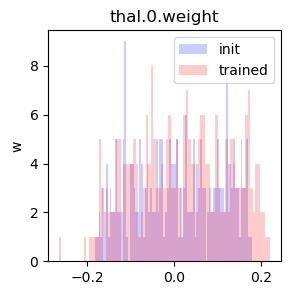

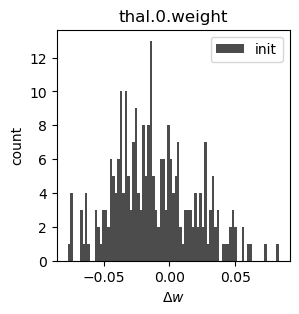

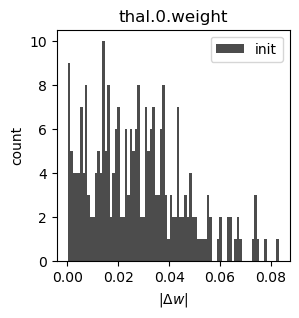

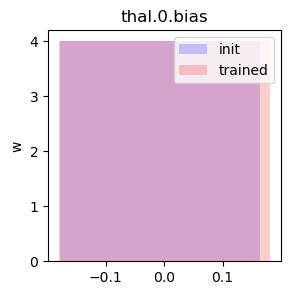

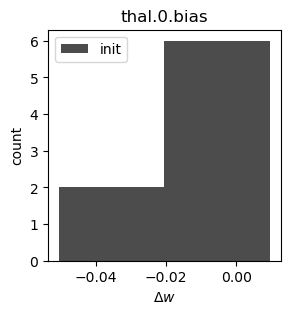

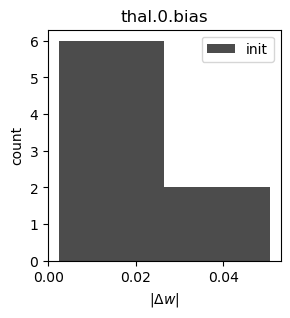

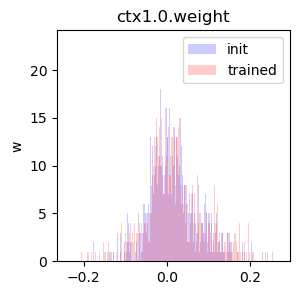

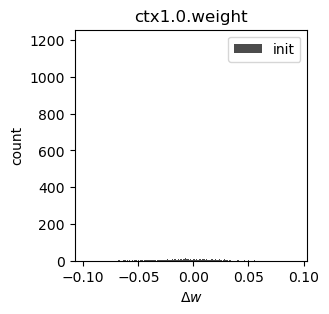

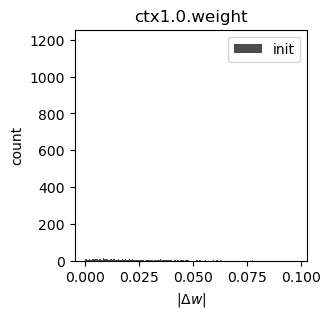

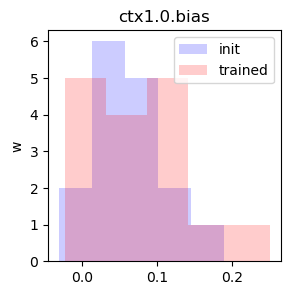

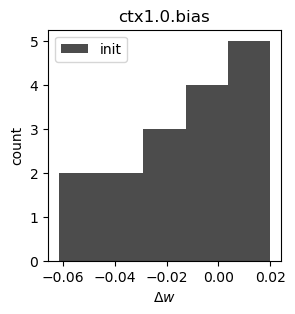

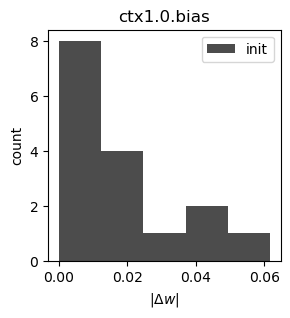

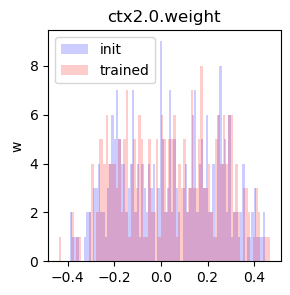

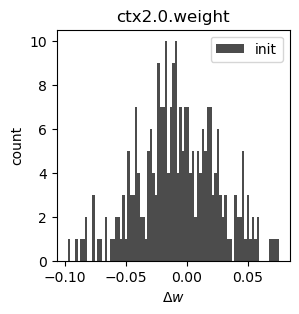

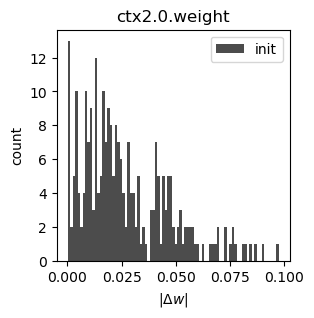

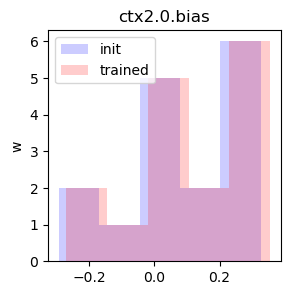

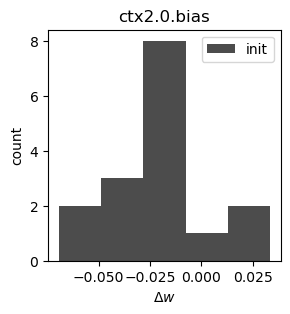

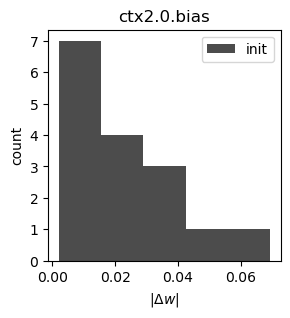

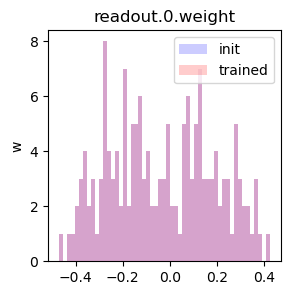

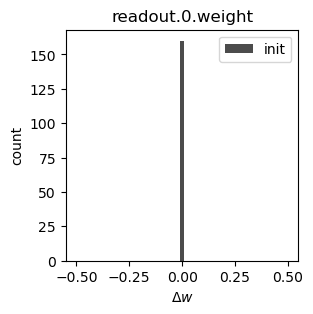

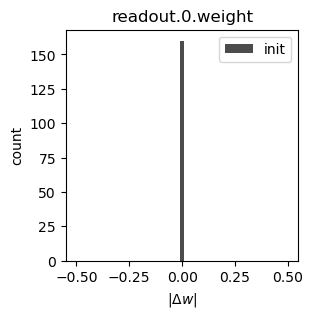

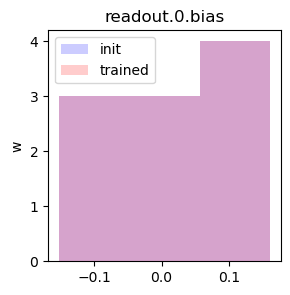

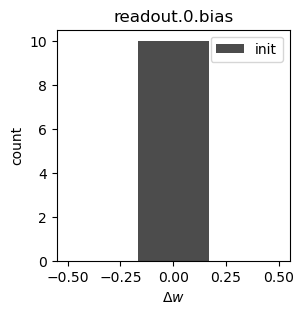

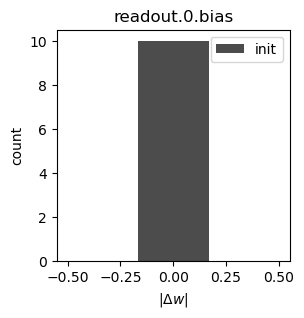

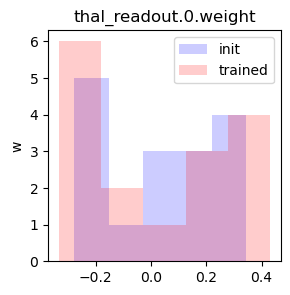

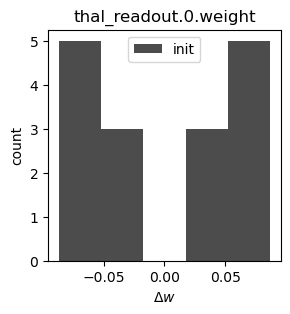

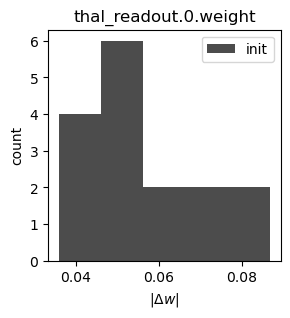

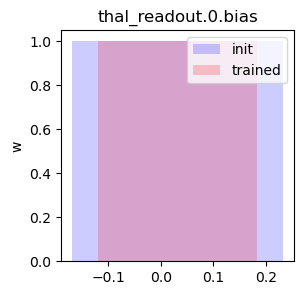

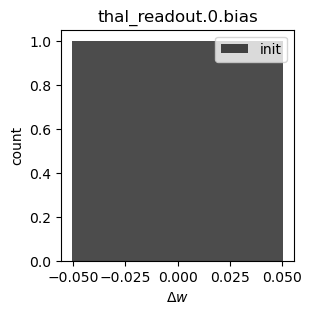

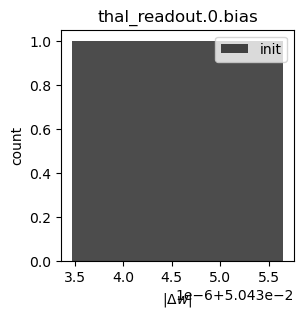

In [13]:
# plot histograms of initial and final weight distributions, and difference distribution
for param_set_name in list(state_dicts[0].keys()):
    # if "weight" in param_set_name:
    params_init = state_dicts[0][param_set_name].flatten()
    params_trained = state_dicts[trained_epoch][param_set_name].flatten()
    params_diff = params_init - params_trained
    params_diff_abs = np.abs(params_diff)

    if len(params_init) // 3 > 1:
        n_bins = len(params_init) // 3
    else:
        n_bins = 2

    print(f"{n_bins=}")

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.hist(params_init, bins=n_bins, facecolor="b", label="init", alpha=0.2)
    ax.hist(params_trained, bins=n_bins, facecolor="r", label="trained", alpha=0.2)
    ax.set_ylabel(f"count")
    ax.set_ylabel(f"w")
    ax.set_title(f"{param_set_name}")
    ax.legend()

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.hist(params_diff, bins=n_bins, facecolor="k", label="init", alpha=0.7)
    ax.set_ylabel(f"count")
    ax.set_xlabel(f"$\Delta{{w}}$")    
    ax.set_title(f"{param_set_name}")
    ax.legend()

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.set_ylabel(f"count")
    ax.set_xlabel(f"|$\Delta{{w}}$|")    
    ax.hist(params_diff_abs, bins=n_bins, facecolor="k", label="init", alpha=0.7)
    ax.set_title(f"{param_set_name}")
    ax.legend()

In [14]:
params_trained

tensor([ 0.1829, -0.1185])

In [15]:
for param_set_name in list(state_dicts[0].keys()):
    print(param_set_name)

thal.0.weight
thal.0.bias
ctx1.0.weight
ctx1.0.bias
ctx2.0.weight
ctx2.0.bias
readout.0.weight
readout.0.bias
thal_readout.0.weight
thal_readout.0.bias


In [16]:
readable_names = {"thal.0.weight": "ctx to thal",
                  "thal.0.bias": "ctx to thal bias",
                  "ctx1.0.weight": "input to ctx1",
                  "ctx1.0.bias": "input to ctx1 bias",
                  "ctx2.0.weight": "ctx1 to ctx2",
                  "ctx2.0.bias": "ctx1 to ctx2 bias",
                  "readout.0.weight": "ctx to readout",
                  "readout.0.bias": "ctx to readout bias",
                  "thal_readout.0.weight": "thal to readout",
                  "thal_readout.0.bias": "thal to readout bias"}

In [17]:
# compute KL divergence between initial and final distributions
# TODO:  convert to prob distributions, otherwise measuring KL divergence doesn't make sense
difference_from_init = {}
metrics = {}
for param_set_name in list(state_dicts[0].keys()):
    difference_from_init[param_set_name] = {"kl_divergence": [], 
                                            "l1": [],
                                            "l2": [],
                                            "l1_normalised": [],
                                            "l2_normalised": [],
                                            "cosine": []}
    metrics[param_set_name] = {"singular_values": [],
                               "spectral_entropy": [],
                               "spectral_norm": [],
                               "condition_number": []}

    # get initial params in vector
    params_init_flat = state_dicts[0][param_set_name].detach().numpy().flatten()

    for epoch in range(len(state_dicts)):
        
        # get params for current epoch in vector
        params_trained = state_dicts[epoch][param_set_name].detach().numpy()
        params_trained_flat = params_trained.flatten()

        # compute difference metrics 
        l1 = np.mean(np.abs(params_init_flat - params_trained_flat))
        l2 = np.mean((params_init_flat - params_trained_flat)**2)
        cosine_distance = 1 - np.sum(params_init_flat * params_trained_flat) / (np.sqrt(np.sum(params_init_flat**2)) * np.sqrt(np.sum(params_trained_flat**2)))
        l1_normalised = l1 / np.mean(np.abs(params_init_flat))
        l2_normalised = l2 / np.mean((params_init_flat)**2)
        params_init_abs_norm = np.abs(params_init_flat)/np.sum(np.abs(params_init_flat))
        params_trained_abs_norm = np.abs(params_trained_flat)/np.sum(np.abs(params_trained_flat))
        params_kl = entropy(params_init_abs_norm, params_trained_abs_norm) # not sure this is valid as don't sum to 1

        # compute metrics
        try:
            singular_vals = np.linalg.svd(params_trained, compute_uv=False)
            singular_vals_norm = singular_vals / np.sum(singular_vals)
            spectral_entropy = entropy(singular_vals_norm)
            spectral_norm = np.max(singular_vals)
            condition_number = np.max(singular_vals) / np.min(singular_vals)
        except:
            singular_vals = None
            singular_vals_norm = None
            spectral_entropy = None
            spectral_norm = None
            condition_number = None
            
        # keep track of metrics
        difference_from_init[param_set_name]["kl_divergence"].append(params_kl)
        difference_from_init[param_set_name]["l1"].append(l1)
        difference_from_init[param_set_name]["l2"].append(l2)
        difference_from_init[param_set_name]["l1_normalised"].append(l1_normalised)
        difference_from_init[param_set_name]["l2_normalised"].append(l2_normalised)
        difference_from_init[param_set_name]["cosine"].append(cosine_distance)
        metrics[param_set_name]["singular_values"].append(singular_vals)
        metrics[param_set_name]["spectral_entropy"].append(spectral_entropy)
        metrics[param_set_name]["spectral_norm"].append(spectral_norm)
        metrics[param_set_name]["condition_number"].append(condition_number)

In [18]:
for param_set_name in list(state_dicts[0].keys()):
    print(f"params: {param_set_name}")
    print(f"shape: {state_dicts[epoch][param_set_name].detach().numpy().shape}")
    if metrics[param_set_name]['singular_values'][0] is not None:
        print(f"num singular vals: {len(metrics[param_set_name]['singular_values'][0])}")
    else:
        print(f"num singular vals: 0")
    print("---------------------")

params: thal.0.weight
shape: (8, 32)
num singular vals: 8
---------------------
params: thal.0.bias
shape: (8,)
num singular vals: 0
---------------------
params: ctx1.0.weight
shape: (16, 784)
num singular vals: 16
---------------------
params: ctx1.0.bias
shape: (16,)
num singular vals: 0
---------------------
params: ctx2.0.weight
shape: (16, 16)
num singular vals: 16
---------------------
params: ctx2.0.bias
shape: (16,)
num singular vals: 0
---------------------
params: readout.0.weight
shape: (10, 16)
num singular vals: 10
---------------------
params: readout.0.bias
shape: (10,)
num singular vals: 0
---------------------
params: thal_readout.0.weight
shape: (2, 8)
num singular vals: 2
---------------------
params: thal_readout.0.bias
shape: (2,)
num singular vals: 0
---------------------


In [19]:
params_plot_list = ["thal.0.weight", "ctx1.0.weight", "ctx2.0.weight", "thal_readout.0.weight"]

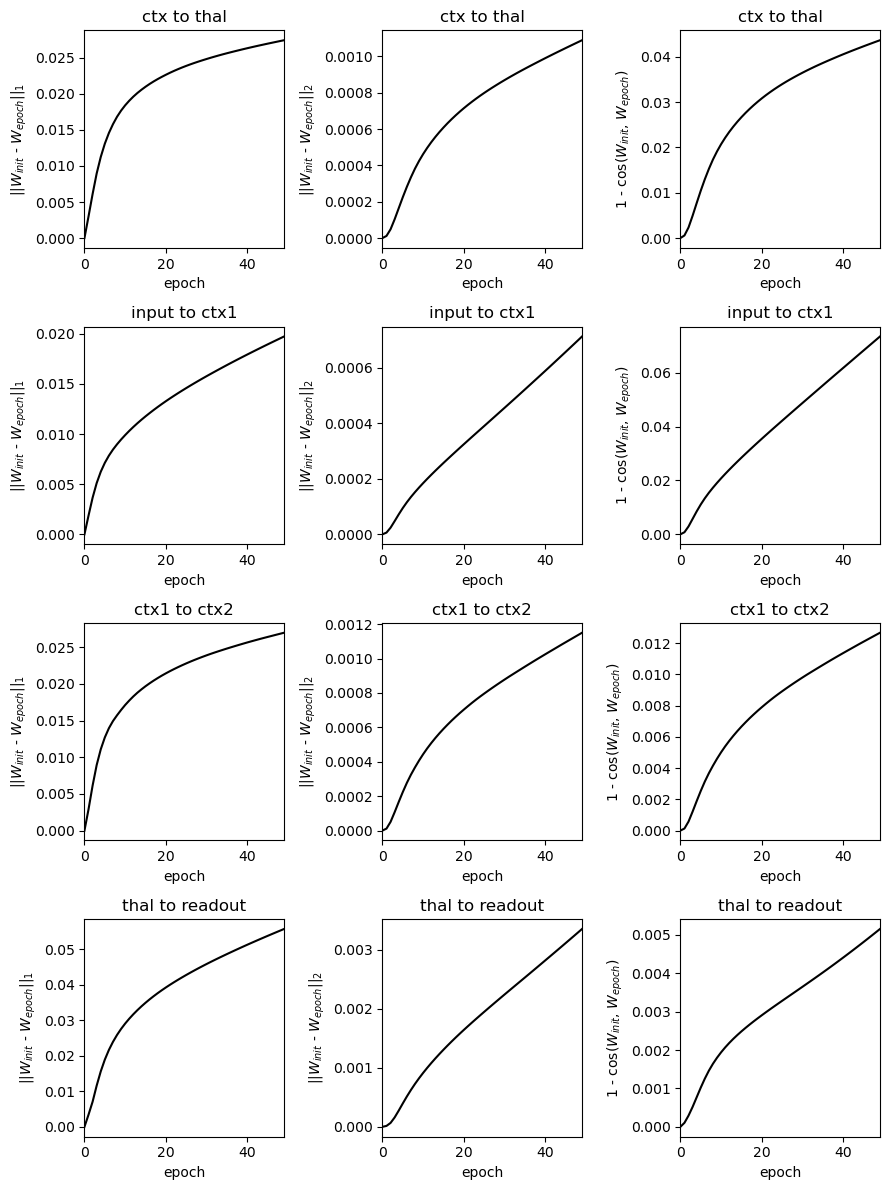

In [20]:
# plot difference metrics
grid_size = 3
fig, ax = plt.subplots(len(params_plot_list), 3, figsize=(3 * grid_size, len(params_plot_list) * grid_size))
param_set_idx = 0
for param_set_name in list(state_dicts[0].keys()):

    if param_set_name in params_plot_list:

        # L1 distance
        ax[param_set_idx, 0].plot(difference_from_init[param_set_name]["l1"], c="k")
        ax[param_set_idx, 0].set_title(f"{readable_names[param_set_name]}")
        ax[param_set_idx, 0].set_ylabel(f"||$W_{{init}}$ - $W_{{epoch}}||_{{1}}$")    
        ax[param_set_idx, 0].set_xlabel(f"epoch")
        ax[param_set_idx, 0].set_xlim(0, len(difference_from_init[param_set_name]["l1"])-1)

        # L2 distance
        ax[param_set_idx, 1].plot(difference_from_init[param_set_name]["l2"], c="k")
        ax[param_set_idx, 1].set_title(f"{readable_names[param_set_name]}")
        ax[param_set_idx, 1].set_ylabel(f"||$W_{{init}}$ - $W_{{epoch}}||_{{2}}$")    
        ax[param_set_idx, 1].set_xlabel(f"epoch")
        ax[param_set_idx, 1].set_xlim(0, len(difference_from_init[param_set_name]["l2"])-1)

        # cosine distance
        ax[param_set_idx, 2].plot(difference_from_init[param_set_name]["cosine"], c="k")
        ax[param_set_idx, 2].set_title(f"{readable_names[param_set_name]}")
        ax[param_set_idx, 2].set_ylabel(f"1 - cos($W_{{init}}$, $W_{{epoch}}$)")    
        ax[param_set_idx, 2].set_xlabel(f"epoch")
        ax[param_set_idx, 2].set_xlim(0, len(difference_from_init[param_set_name]["cosine"])-1)

        param_set_idx += 1

fig.set_tight_layout(True)

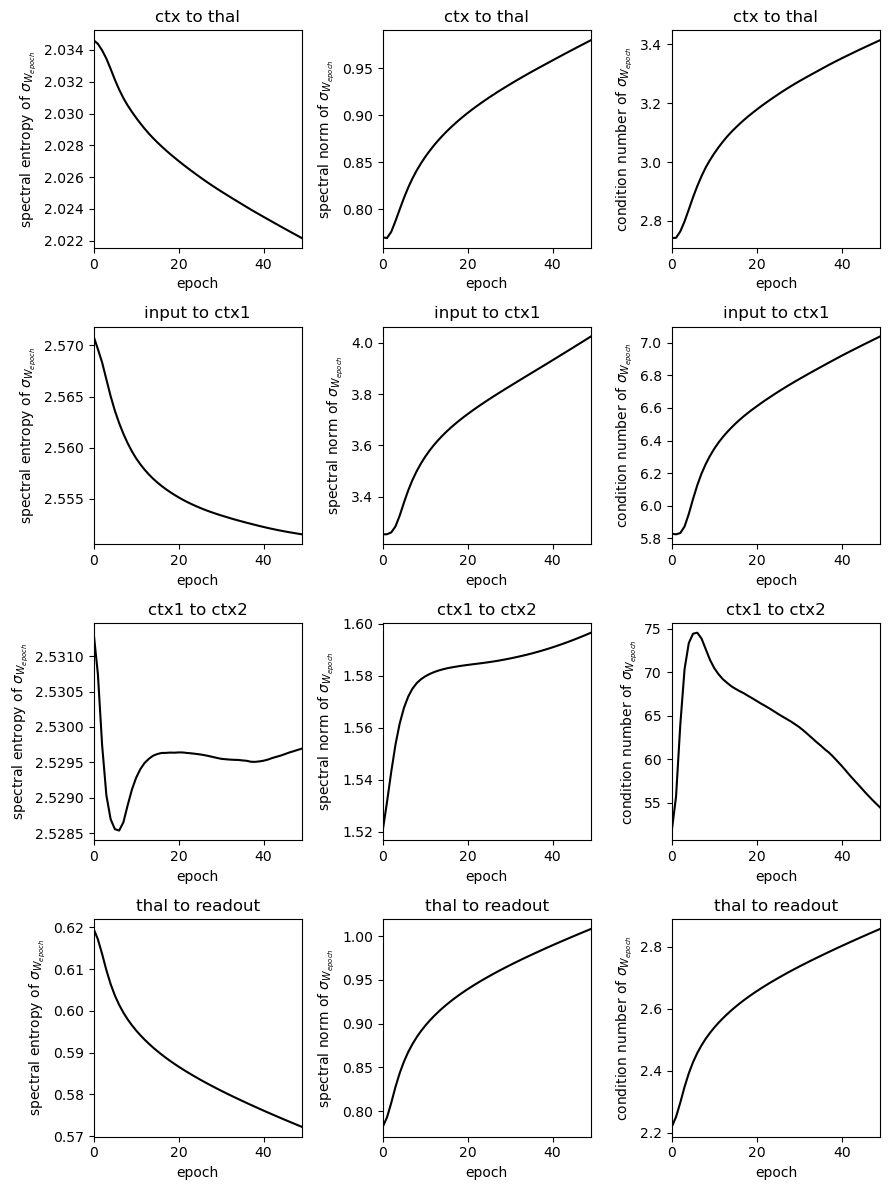

In [21]:
# plot connection-wise metrics
grid_size = 3
fig, ax = plt.subplots(len(params_plot_list), 3, figsize=(3 * grid_size, len(params_plot_list) * grid_size))
param_set_idx = 0
for param_set_name in list(state_dicts[0].keys()):

    if param_set_name in params_plot_list:
        
        # spectral entropy
        ax[param_set_idx, 0].plot(metrics[param_set_name]["spectral_entropy"], c="k")
        ax[param_set_idx, 0].set_title(f"{readable_names[param_set_name]}")
        ax[param_set_idx, 0].set_ylabel(f"spectral entropy of $\sigma_{{W_{{epoch}}}}$")    
        ax[param_set_idx, 0].set_xlabel(f"epoch")
        ax[param_set_idx, 0].set_xlim(0, len(metrics[param_set_name]["spectral_entropy"])-1)

        # spectral norm
        ax[param_set_idx, 1].plot(metrics[param_set_name]["spectral_norm"], c="k")
        ax[param_set_idx, 1].set_title(f"{readable_names[param_set_name]}")
        ax[param_set_idx, 1].set_ylabel(f"spectral norm of $\sigma_{{W_{{epoch}}}}$")    
        ax[param_set_idx, 1].set_xlabel(f"epoch")
        ax[param_set_idx, 1].set_xlim(0, len(metrics[param_set_name]["spectral_norm"])-1)

        # condition number
        ax[param_set_idx, 2].plot(metrics[param_set_name]["condition_number"], c="k")
        ax[param_set_idx, 2].set_title(f"{readable_names[param_set_name]}")
        ax[param_set_idx, 2].set_ylabel(f"condition number of $\sigma_{{W_{{epoch}}}}$")    
        ax[param_set_idx, 2].set_xlabel(f"epoch")
        ax[param_set_idx, 2].set_xlim(0, len(metrics[param_set_name]["condition_number"])-1)

        param_set_idx += 1

fig.set_tight_layout(True)

In [22]:
# plot initial vs final weight differences for different layers
final_epoch = 49
l1_normalised_changes = {}
l2_normalised_changes = {}
for param_set_name in list(state_dicts[0].keys()):
    if param_set_name in params_plot_list:
        l1_normalised_changes[param_set_name] = difference_from_init[param_set_name]["l1_normalised"][final_epoch]
        l2_normalised_changes[param_set_name] = difference_from_init[param_set_name]["l2_normalised"][final_epoch]
        param_set_idx += 1

In [23]:
# ax_labels = [readable_names[param_set_name] for param_set_name in params_plot_list]
# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# ax.bar(l1_normalised_changes.keys(), l1_normalised_changes.values(), facecolor="b")
# ax.set_xticklabels(ax_labels, rotation=45)
# ax.set_ylabel(f"$\dfrac{{||W_{{init}} - W_{{{final_epoch}}}||_{{1}}}}{{||W_{{init}}||_{{1}}}}$")
# fig.set_tight_layout(True)

/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_7554/2669236991.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax_labels, rotation=45)


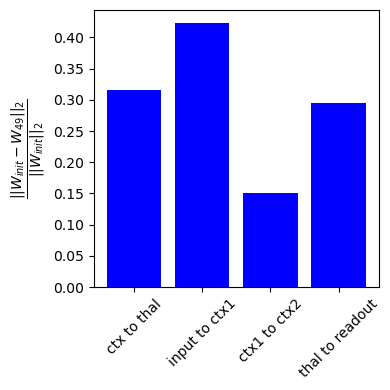

In [25]:
ax_labels = [readable_names[param_set_name] for param_set_name in params_plot_list]
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.bar(l2_normalised_changes.keys(), l1_normalised_changes.values(), facecolor="b")
ax.set_xticklabels(ax_labels, rotation=45)
ax.set_ylabel(f"$\dfrac{{||W_{{init}} - W_{{{final_epoch}}}||_{{2}}}}{{||W_{{init}}||_{{2}}}}$")
fig.set_tight_layout(True)

In [26]:
input_layer_weights = state_dicts[-1][param_set_name].detach().numpy().flatten()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

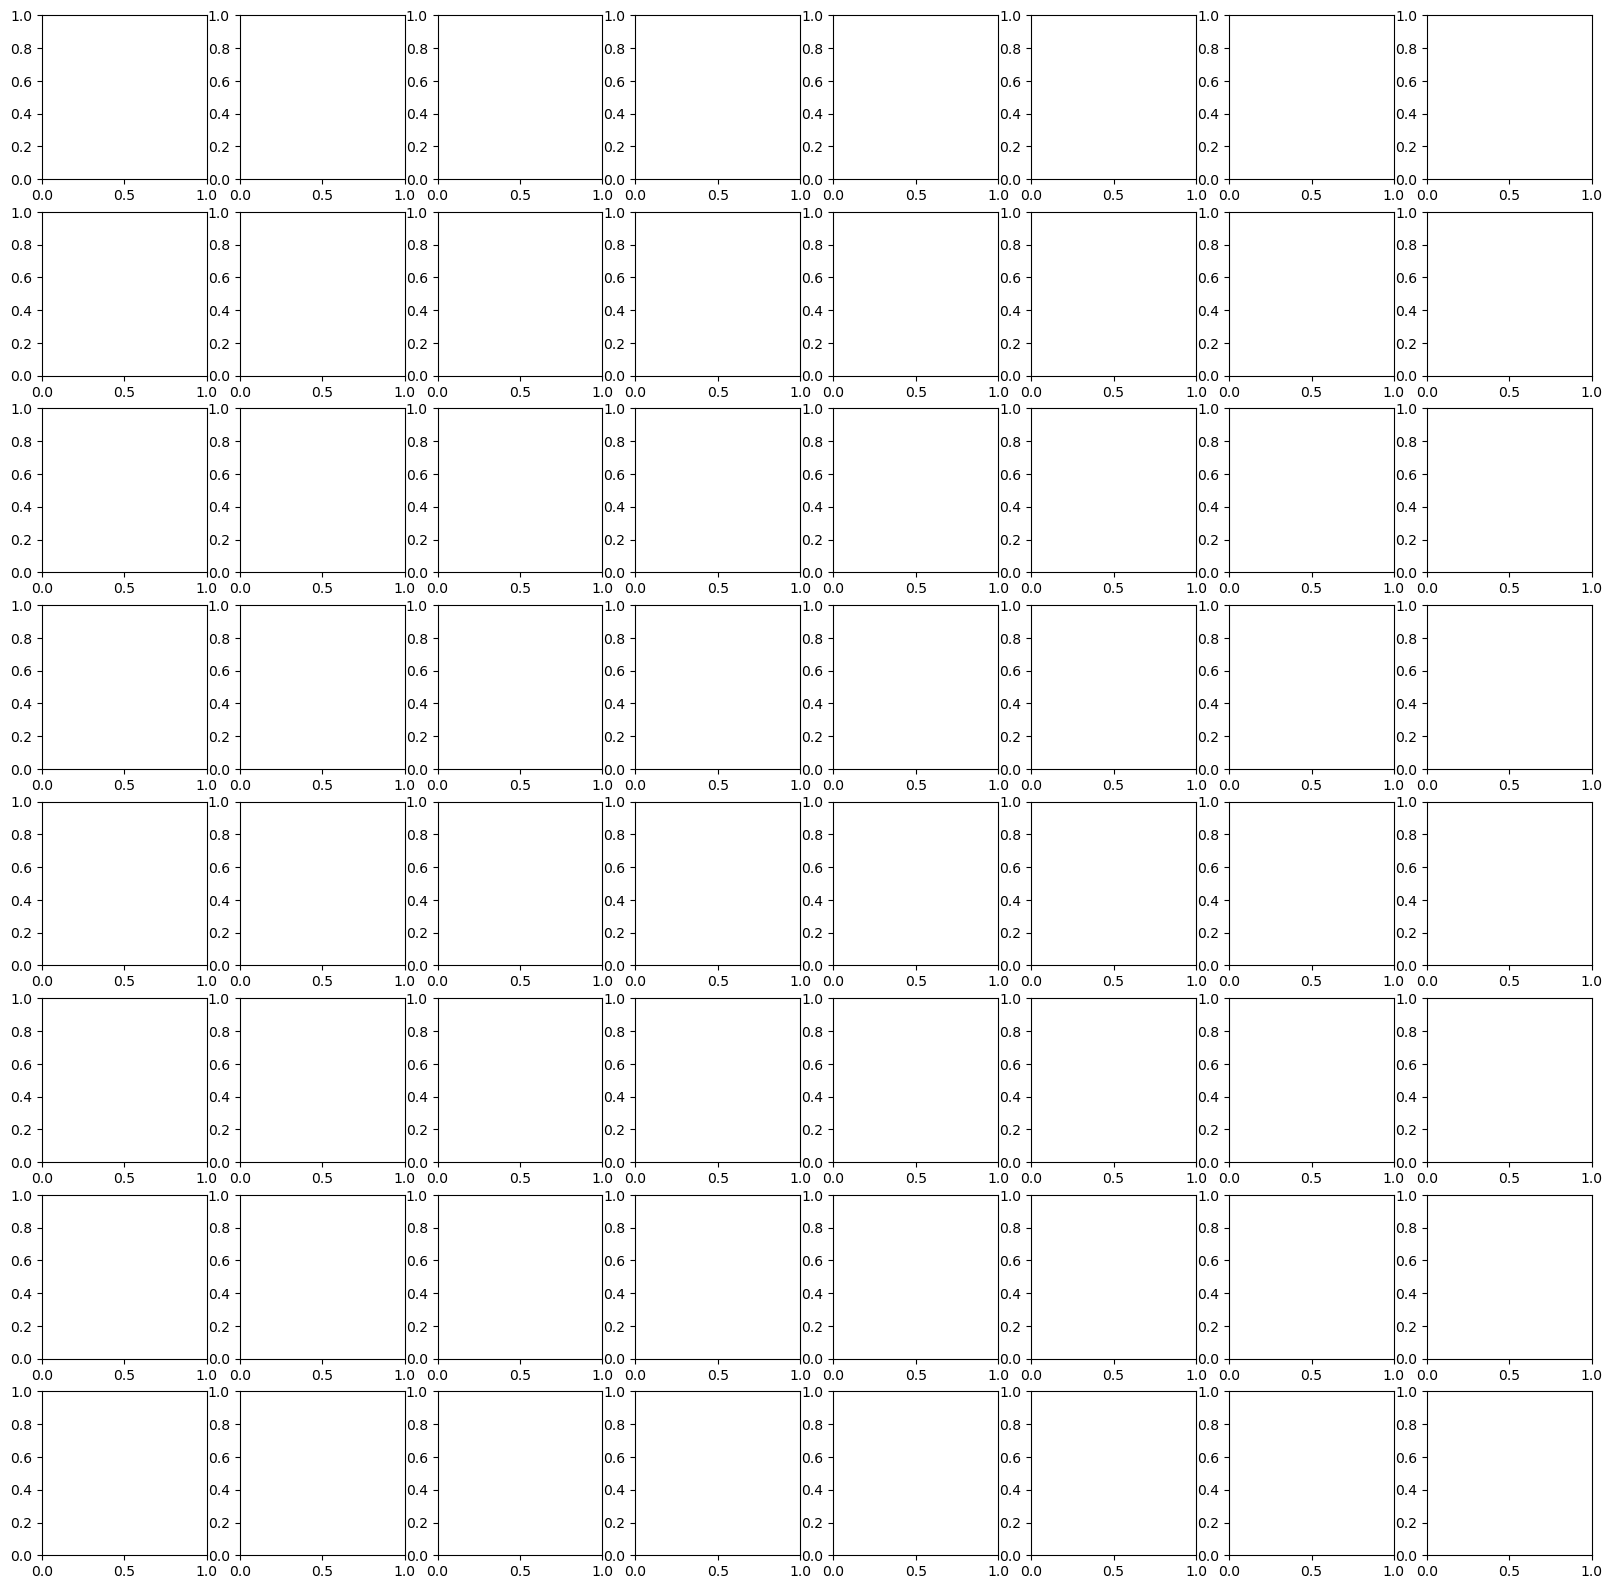

In [27]:
# plot initial vs final receptive fields for input layer
cmap = cm.get_cmap("seismic")
clims = [-0.2, 0.2]

fig, ax = plt.subplots(8, 8, figsize=(20, 20))

for neuron_id in range(64):

    row_idx = neuron_id // 8
    col_idx = neuron_id % 8

    weights_this_neuron = get_neuron_weights(weights=input_layer_weights,
                                             neuron_id=neuron_id)
    plot_receptive_field(weights=weights_this_neuron,
                         ax=ax[row_idx, col_idx],
                         cmap=cmap,
                         clims=clims,
                         title=neuron_id)

psm = ax[0, 0].pcolormesh(weights_this_neuron, cmap=cmap, rasterized=True, vmin=clims[0], vmax=clims[1])
cbar = fig.colorbar(psm, ax=ax)
cbar.set_label("weight")
fig.suptitle("input layer receptive fields")
# fig.set_tight_layout(True)